<a href="https://colab.research.google.com/github/drueda869/Estad-stica/blob/main/Taller_estad%C3%ADstica_regresi%C3%B3n_lineal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install statsmodels


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

plt.rcParams["figure.figsize"] = (6,4)

# ---------- UTILIDADES GRAFICAS ----------
def plot_histograms(df, cols):
    fig, axes = plt.subplots(1, len(cols), figsize=(6*len(cols), 4))
    if len(cols) == 1: axes = [axes]
    for ax, c in zip(axes, cols):
        ax.hist(df[c], bins=8, edgecolor="k")
        ax.set_title(f"Histograma: {c}")
    plt.show()

def plot_scatter_with_line(x, y, b0=None, b1=None, title="Dispersión y recta"):
    plt.scatter(x, y)
    if b0 is not None and b1 is not None:
        xs = np.linspace(np.min(x), np.max(x), 100)
        plt.plot(xs, b0 + b1*xs, linestyle="--", linewidth=2, label=f"Ŷ={b0:.3f}+{b1:.3f}X")
        plt.legend()
    plt.title(title); plt.xlabel("X"); plt.ylabel("Y")
    plt.grid(True); plt.show()

def plot_residual_diagnostics(results, x, y, title_prefix=""):
    yhat = results.fittedvalues
    resid = results.resid
    # 1) residuos vs predichos
    plt.scatter(yhat, resid); plt.axhline(0, color="k", lw=1)
    plt.title(f"{title_prefix}Residuos vs Predichos"); plt.xlabel("Ŷ"); plt.ylabel("e")
    plt.grid(True); plt.show()
    # 2) residuos vs X
    plt.scatter(x, resid); plt.axhline(0, color="k", lw=1)
    plt.title(f"{title_prefix}Residuos vs X"); plt.xlabel("X"); plt.ylabel("e")
    plt.grid(True); plt.show()
    # 3) histograma
    plt.hist(resid, bins=8, edgecolor="k"); plt.title(f"{title_prefix}Histograma residuos")
    plt.show()
    # 4) QQ plot
    sm.qqplot(resid, line="45"); plt.title(f"{title_prefix}QQ-plot residuos")
    plt.show()

def t_curve_for_rtest(t_stat, df, alpha=0.05, side="two-sided", title="Prueba sobre r (t)"):
    # Solo para visual: curva t con región de rechazo y t observado
    xs = np.linspace(-5,5,400)
    pdf = stats.t.pdf(xs, df)
    plt.plot(xs, pdf, lw=2, label=f"t(df={df})")

    if side == "two-sided":
        tc = stats.t.ppf(1 - alpha/2, df)
        mask = (xs>=tc)|(xs<=-tc)
        plt.fill_between(xs, 0, pdf, where=mask, alpha=0.3, label=f"Rechazo |t| ≥ {tc:.2f}")
    elif side == "greater":
        tc = stats.t.ppf(1 - alpha, df)
        mask = (xs>=tc)
        plt.fill_between(xs, 0, pdf, where=mask, alpha=0.3, label=f"Rechazo t ≥ {tc:.2f}")
    else:
        tc = stats.t.ppf(alpha, df)
        mask = (xs<=tc)
        plt.fill_between(xs, 0, pdf, where=mask, alpha=0.3, label=f"Rechazo t ≤ {tc:.2f}")

    plt.axvline(t_stat, ls="--", lw=2, label=f"t calc = {t_stat:.2f}")
    plt.title(title); plt.legend(); plt.grid(True); plt.show()

# ---------- ESTADÍSTICA ----------
def shapiro_tests(df, cols):
    out = {}
    for c in cols:
        w, p = stats.shapiro(df[c])
        out[c] = {"W": w, "pvalue": p}
    return pd.DataFrame(out).T

def all_correlations(x, y):
    pear = stats.pearsonr(x, y)  # (r, p)
    spear = stats.spearmanr(x, y)  # (rho, p)
    kend = stats.kendalltau(x, y)  # (tau, p)
    return {
        "pearson_r": pear[0], "pearson_p": pear[1],
        "spearman_rho": spear.statistic, "spearman_p": spear.pvalue,
        "kendall_tau": kend.statistic, "kendall_p": kend.pvalue
    }

def pearson_t_test(r, n, alpha=0.05):
    # t = r*sqrt(n-2)/sqrt(1-r^2), gl=n-2
    df = n - 2
    t_stat = r*np.sqrt(df)/np.sqrt(1 - r**2)
    p_two = 2*(1 - stats.t.cdf(abs(t_stat), df))
    return t_stat, df, p_two

def fit_linear(x, y):
    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()
    return model  # results

def regression_anova(results):
    # anova = sm.stats.anova_lm(results, typ=1) # Old method
    anova = pd.DataFrame({
        'df': results.df_model,
        'sum_sq': results.ess,
        'mean_sq': results.ess / results.df_model,
        'F': results.fvalue,
        'PR(>F)': results.f_pvalue
    }, index=['model'])
    anova = anova.append(pd.DataFrame({
        'df': results.df_resid,
        'sum_sq': results.ssr,
        'mean_sq': results.ssr / results.df_resid,
        'F': np.nan,
        'PR(>F)': np.nan
    }, index=['residual']))
    return anova

def conf_pred_intervals(results, x_new, alpha=0.05):
    # IC de la media y PI individual
    # pred = results.get_prediction(exog=sm.add_constant(pd.DataFrame({"x": x_new}))) # Old method
    exog = sm.add_constant(pd.DataFrame({"x": x_new}))
    pred = results.get_prediction(exog=exog)

    frame = pred.summary_frame(alpha=alpha)  # obs_ci_* son PI
    # Renombrar columnas principales
    frame = frame.rename(columns={
        "mean": "yhat",
        "mean_ci_lower": "IC_low", "mean_ci_upper": "IC_high",
        "obs_ci_lower": "PI_low", "obs_ci_upper": "PI_high"
    })
    return frame

,X,Y
count,6.000000,6.000000
mean,38.666667,31.166667
std,8.594572,6.112828
min,27.000000,22.000000
25%,32.750000,28.250000
50%,39.500000,31.000000
75%,44.000000,35.250000
max,50.000000,39.000000


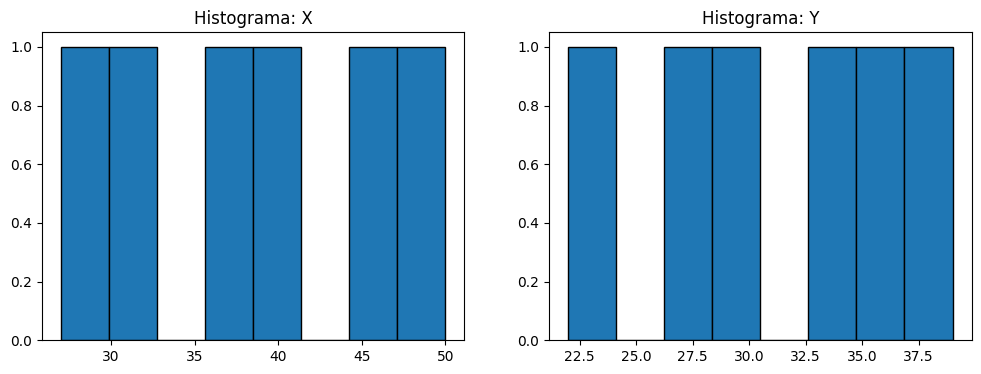

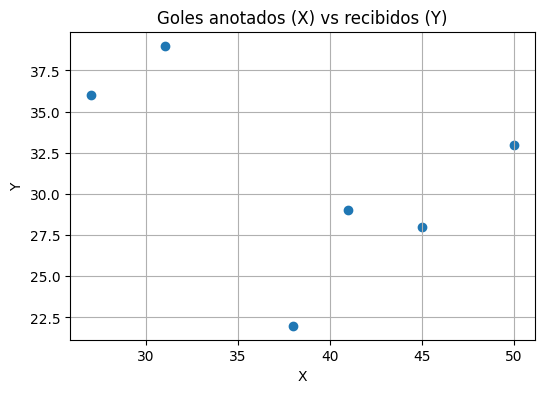

,W,pvalue
X,0.975696,0.928272
Y,0.979696,0.950035


r = -0.4365, t = -0.9704, gl = 4, p(two) = 0.3868


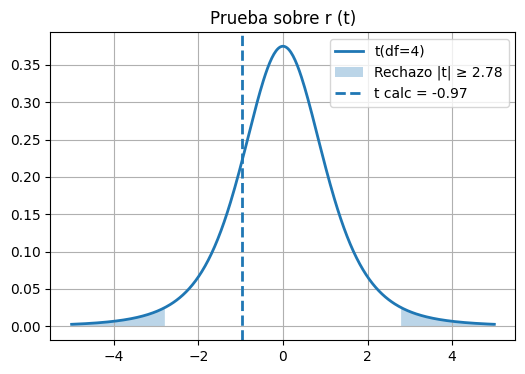

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                 -0.012
Method:                 Least Squares   F-statistic:                    0.9416
Date:                Fri, 07 Nov 2025   Prob (F-statistic):              0.387
Time:                        12:18:42   Log-Likelihood:                -18.195
No. Observations:                   6   AIC:                             40.39
Df Residuals:                       4   BIC:                             39.97
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         43.1715     12.624      3.420      0.0

/usr/local/lib/python3.12/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


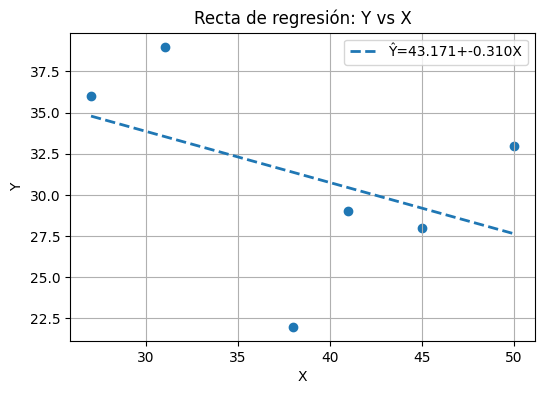

AttributeError: 'PandasData' object has no attribute 'design_info'

In [12]:
# Datos
equipos = ["Leones","Águilas","Tigres","Toros","Pumas","Jaguares"]
X = np.array([38,45,31,50,27,41], dtype=float)  # Goles anotados
Y = np.array([22,28,39,33,36,29], dtype=float)  # Goles recibidos
df1 = pd.DataFrame({"Equipo": equipos, "X": X, "Y": Y})

# 1) EDA
display(df1.describe())
plot_histograms(df1, ["X","Y"])
plot_scatter_with_line(df1["X"], df1["Y"], title="Goles anotados (X) vs recibidos (Y)")

# 2) Normalidad
display(shapiro_tests(df1, ["X","Y"]))

# 3) Correlaciones
corrs = all_correlations(df1["X"], df1["Y"])
corrs

# 4) Prueba de hipótesis para r (Pearson)
r = corrs["pearson_r"]; n = len(df1)
t_stat, df, p_two = pearson_t_test(r, n, alpha=0.05)
print(f"r = {r:.4f}, t = {t_stat:.4f}, gl = {df}, p(two) = {p_two:.4f}")
t_curve_for_rtest(t_stat, df, alpha=0.05, side="two-sided")

# 5) Modelo de regresión: Y = b0 + b1 X
res = fit_linear(df1["X"], df1["Y"])
print(res.summary())
b0, b1 = res.params["const"], res.params["X"]
plot_scatter_with_line(df1["X"], df1["Y"], b0, b1, "Recta de regresión: Y vs X")

# 6) Significancia de la pendiente y ANOVA de regresión
anova1 = regression_anova(res)
anova1

# 7) R^2
print(f"R^2 = {res.rsquared:.4f}  ({res.rsquared*100:.2f}%)")

# 8–9) Intervalos para una X nueva (ejemplo: X=40)
x_new = pd.Series([40])
conf_pred_intervals(res, x_new)

,X,Y
count,12.000000,12.000000
mean,7.583333,80.666667
std,2.151462,8.499554
min,4.000000,65.000000
25%,6.000000,76.250000
50%,7.500000,81.000000
75%,9.250000,85.750000
max,11.000000,94.000000


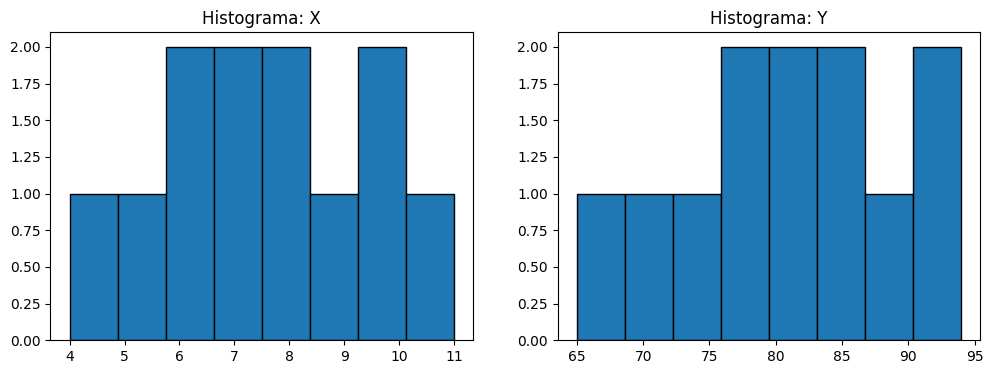

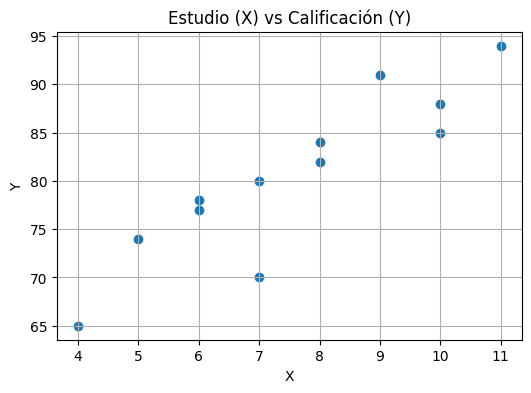

,W,pvalue
X,0.971299,0.923925
Y,0.988649,0.999401


0.8965066804425252 6.39911894949887 10 7.841337084935063e-05


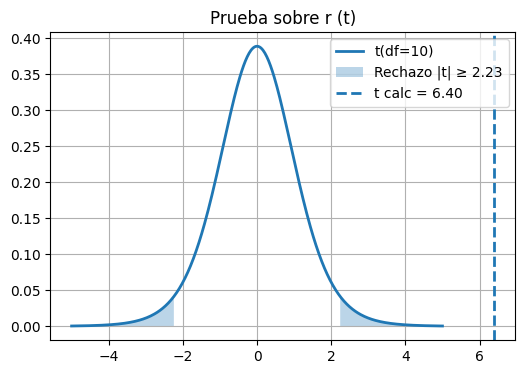

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                     40.95
Date:                Fri, 07 Nov 2025   Prob (F-statistic):           7.84e-05
Time:                        12:18:43   Log-Likelihood:                -32.416
No. Observations:                  12   AIC:                             68.83
Df Residuals:                      10   BIC:                             69.80
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         53.8085      4.349     12.372      0.0

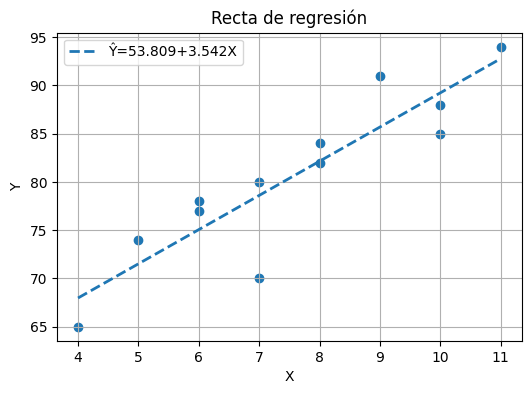

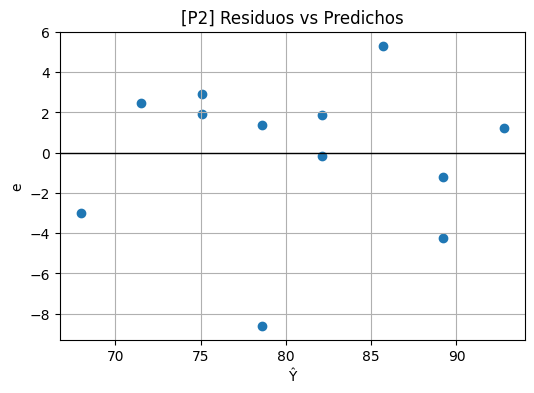

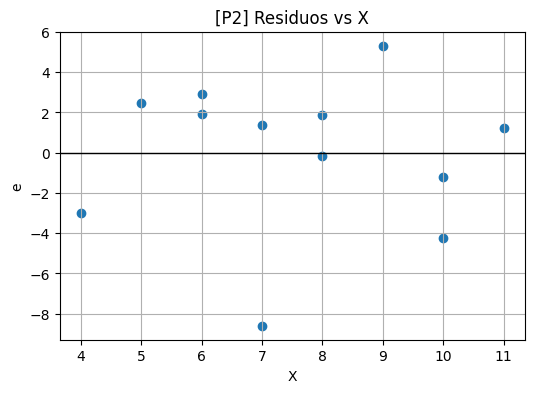

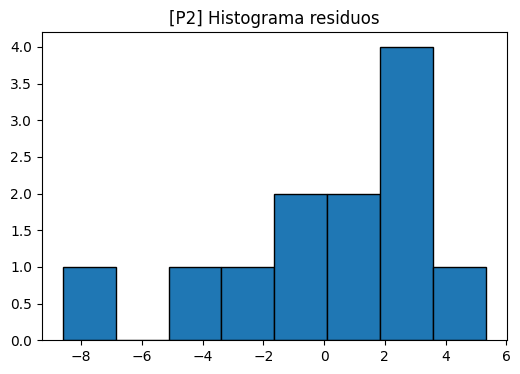

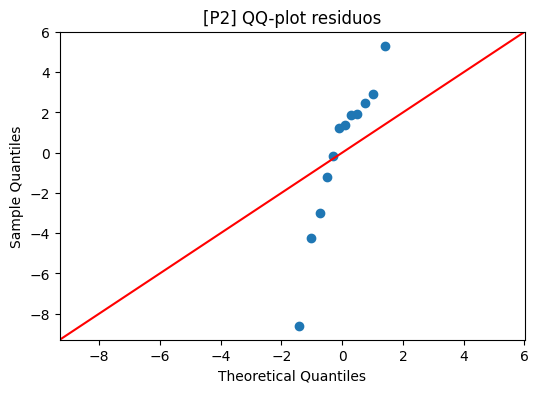

AttributeError: 'PandasData' object has no attribute 'design_info'

In [13]:
X = np.array([4,7,10,6,8,9,5,11,7,6,8,10], dtype=float)
Y = np.array([65,70,85,78,82,91,74,94,80,77,84,88], dtype=float)
df2 = pd.DataFrame({"X": X, "Y": Y})

# EDA
display(df2.describe())
plot_histograms(df2, ["X","Y"])
plot_scatter_with_line(df2["X"], df2["Y"], title="Estudio (X) vs Calificación (Y)")

# Normalidad
display(shapiro_tests(df2, ["X","Y"]))

# Correlaciones
corrs = all_correlations(df2["X"], df2["Y"]); corrs

# Prueba H0: rho=0
r = corrs["pearson_r"]; n = len(df2)
t_stat, df, p_two = pearson_t_test(r, n); print(r, t_stat, df, p_two)
t_curve_for_rtest(t_stat, df)

# Regresión
res = fit_linear(df2["X"], df2["Y"])
print(res.summary())
b0, b1 = res.params["const"], res.params["X"]
plot_scatter_with_line(df2["X"], df2["Y"], b0, b1, "Recta de regresión")

# Diagnóstico de residuos
plot_residual_diagnostics(res, df2["X"], df2["Y"], title_prefix="[P2] ")

# ANOVA y R^2
display(regression_anova(res))
print(f"R^2 = {res.rsquared:.4f}")

,X,Y
count,10.000000,10.000000
mean,19.600000,7.400000
std,3.204164,2.065591
min,15.000000,5.000000
25%,17.250000,6.000000
50%,19.500000,7.000000
75%,21.750000,8.750000
max,25.000000,11.000000


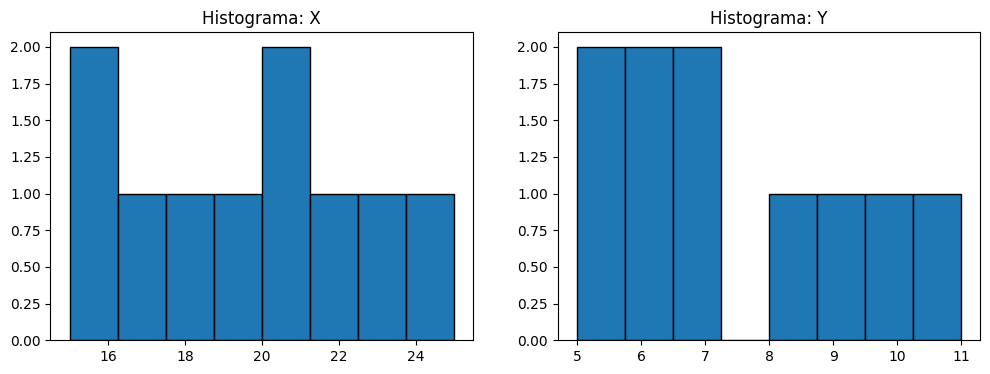

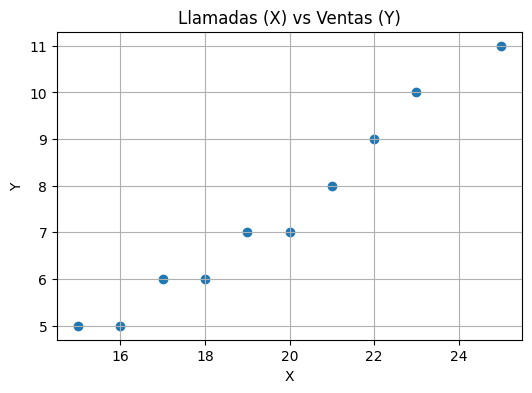

,W,pvalue
X,0.980878,0.969693
Y,0.929942,0.447326


0.9837755352476516 15.509919993786488 8 2.9728903894188363e-07


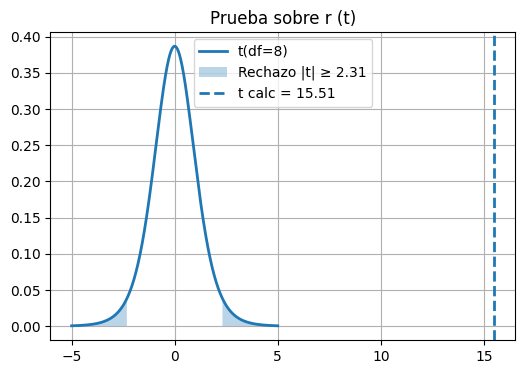

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     240.6
Date:                Fri, 07 Nov 2025   Prob (F-statistic):           2.97e-07
Time:                        12:18:45   Log-Likelihood:                -3.7356
No. Observations:                  10   AIC:                             11.47
Df Residuals:                       8   BIC:                             12.08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.0303      0.811     -6.202      0.0

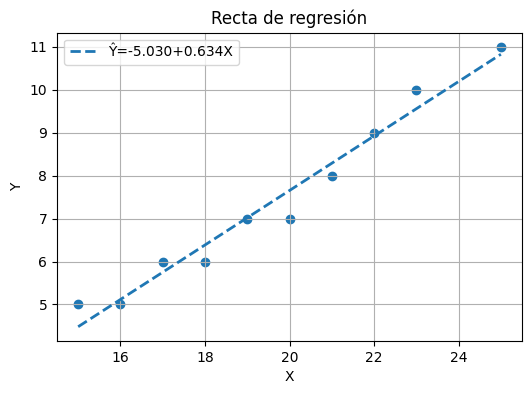

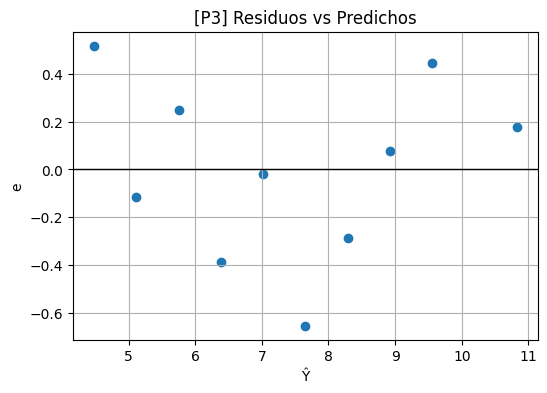

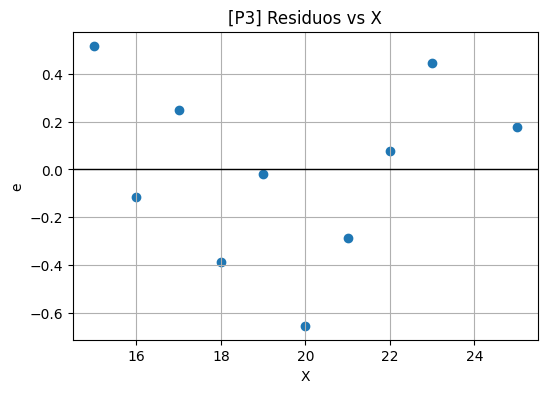

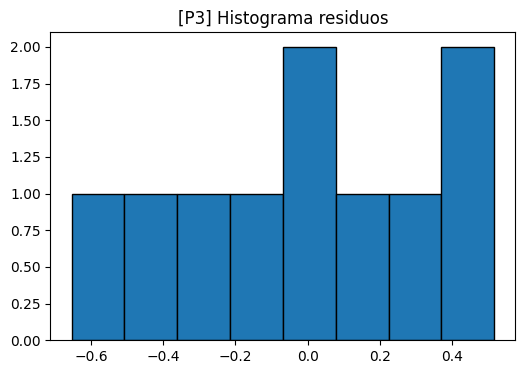

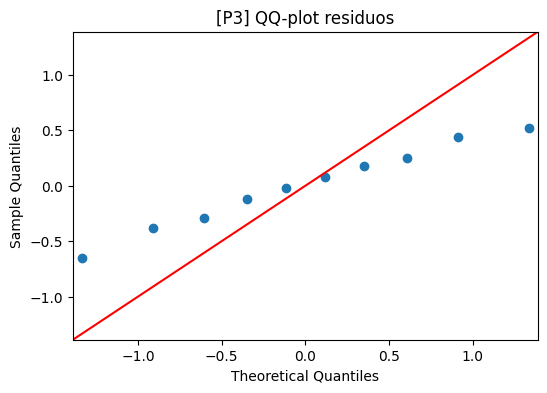

AttributeError: 'PandasData' object has no attribute 'design_info'

In [14]:
X = np.array([15,20,18,25,22,17,19,23,21,16], dtype=float)
Y = np.array([5,7,6,11,9,6,7,10,8,5], dtype=float)
df3 = pd.DataFrame({"X": X, "Y": Y})

# EDA
display(df3.describe())
plot_histograms(df3, ["X","Y"])
plot_scatter_with_line(df3["X"], df3["Y"], title="Llamadas (X) vs Ventas (Y)")

# Normalidad
display(shapiro_tests(df3, ["X","Y"]))

# Correlaciones y prueba
corrs = all_correlations(df3["X"], df3["Y"]); corrs
r = corrs["pearson_r"]; n = len(df3)
t_stat, df, p_two = pearson_t_test(r, n); print(r, t_stat, df, p_two)
t_curve_for_rtest(t_stat, df)

# Regresión
res = fit_linear(df3["X"], df3["Y"])
print(res.summary())
b0, b1 = res.params["const"], res.params["X"]
plot_scatter_with_line(df3["X"], df3["Y"], b0, b1, "Recta de regresión")

# Diagnóstico
plot_residual_diagnostics(res, df3["X"], df3["Y"], title_prefix="[P3] ")
display(regression_anova(res))
print(f"R^2 = {res.rsquared:.4f}")


===== Región 1 =====


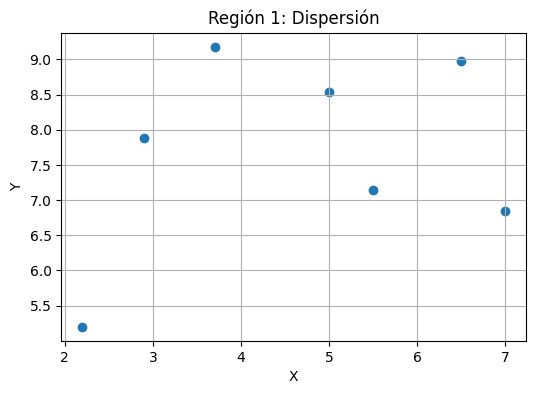

,W,pvalue
X,0.951932,0.747248
Y,0.931844,0.566687


{'pearson_r': np.float64(0.30117408636795057), 'pearson_p': np.float64(0.5115804386234208), 'spearman_rho': np.float64(0.10714285714285716), 'spearman_p': np.float64(0.8191508555699912), 'kendall_tau': np.float64(0.04761904761904762), 'kendall_p': np.float64(1.0)}
Prueba r: t=0.706, gl=5, p(two)=0.5116


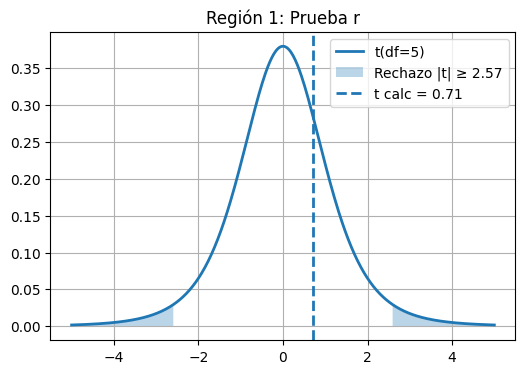

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                 -0.091
Method:                 Least Squares   F-statistic:                    0.4988
Date:                Fri, 07 Nov 2025   Prob (F-statistic):              0.512
Time:                        12:18:46   Log-Likelihood:                -11.439
No. Observations:                   7   AIC:                             26.88
Df Residuals:                       5   BIC:                             26.77
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.5902      1.644      4.010      0.0

/usr/local/lib/python3.12/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


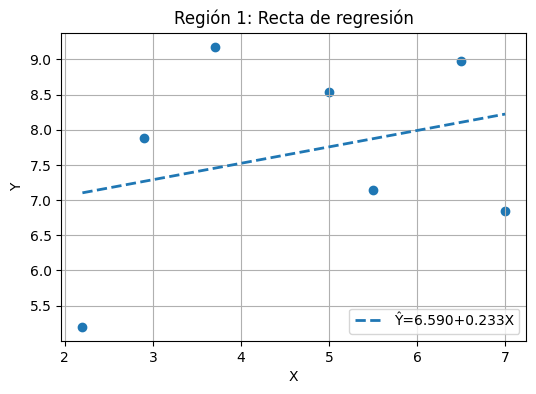

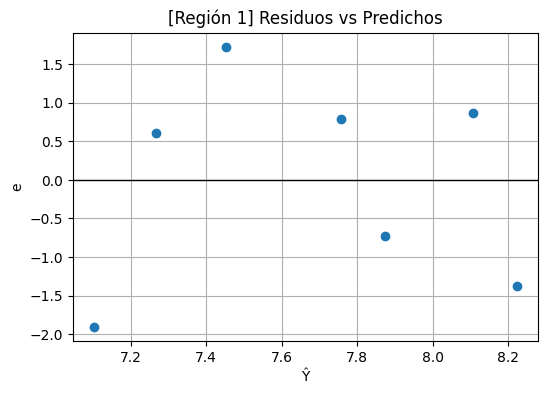

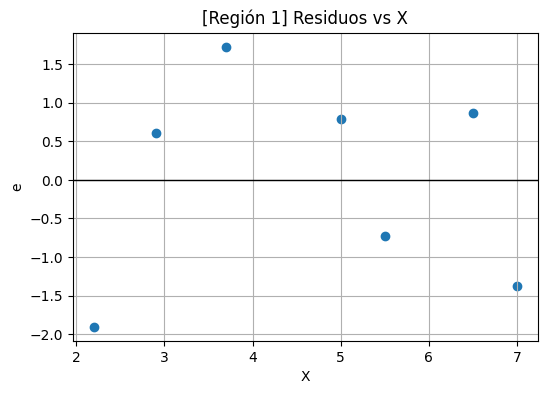

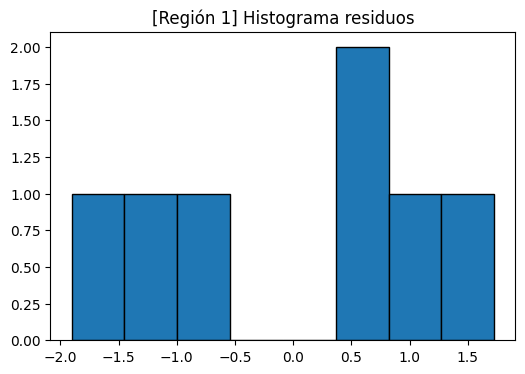

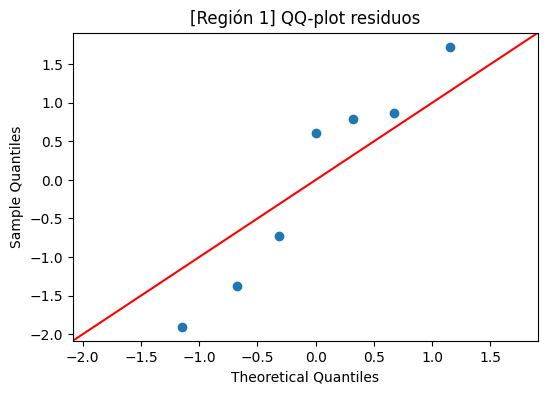

AttributeError: 'PandasData' object has no attribute 'design_info'

In [15]:
# Región 1
r1 = pd.DataFrame({"X":[3.7,5.0,7.0,6.5,2.2,5.5,2.9],
                   "Y":[9.18,8.54,6.85,8.98,5.20,7.15,7.88]})
# Región 2
r2 = pd.DataFrame({"X":[4.2,3.4,2.5,1.5,3.7,4.9,3.2],
                   "Y":[5.65,3.26,2.25,1.95,3.34,7.23,4.45]})
# Región 3
r3 = pd.DataFrame({"X":[2.2,1.6,2.3,2.9,3.2,3.7,4.4,4.8,5.0],
                   "Y":[2.05,1.43,2.44,2.95,3.16,3.95,4.25,5.39,5.64]})

def pipeline_region(df, name, alpha=0.05):
    print(f"\n===== {name} =====")
    plot_scatter_with_line(df["X"], df["Y"], title=f"{name}: Dispersión")
    display(shapiro_tests(df, ["X","Y"]))
    corrs = all_correlations(df["X"], df["Y"]); print(corrs)
    r = corrs["pearson_r"]; n = len(df)
    t_stat, gl, p_two = pearson_t_test(r, n, alpha)
    print(f"Prueba r: t={t_stat:.3f}, gl={gl}, p(two)={p_two:.4g}")
    t_curve_for_rtest(t_stat, gl, alpha, "two-sided", f"{name}: Prueba r")
    res = fit_linear(df["X"], df["Y"])
    print(res.summary())
    b0, b1 = res.params["const"], res.params["X"]
    plot_scatter_with_line(df["X"], df["Y"], b0, b1, f"{name}: Recta de regresión")
    plot_residual_diagnostics(res, df["X"], df["Y"], title_prefix=f"[{name}] ")
    display(regression_anova(res))
    print(f"R^2 = {res.rsquared:.3f}")

pipeline_region(r1, "Región 1")
pipeline_region(r2, "Región 2")
pipeline_region(r3, "Región 3")

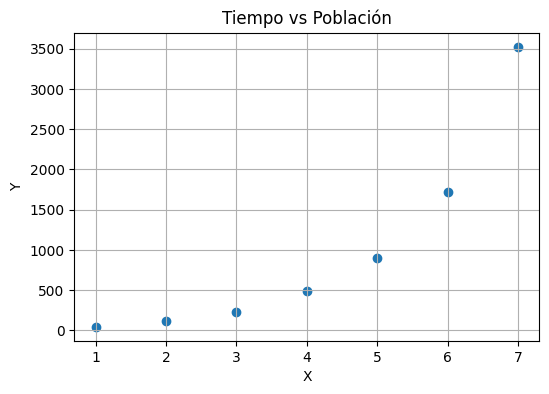

                            OLS Regression Results                            
Dep. Variable:                    pop   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     17.17
Date:                Fri, 07 Nov 2025   Prob (F-statistic):            0.00896
Time:                        12:18:48   Log-Likelihood:                -54.132
No. Observations:                   7   AIC:                             112.3
Df Residuals:                       5   BIC:                             112.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1045.0000    552.385     -1.892      0.1

/usr/local/lib/python3.12/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


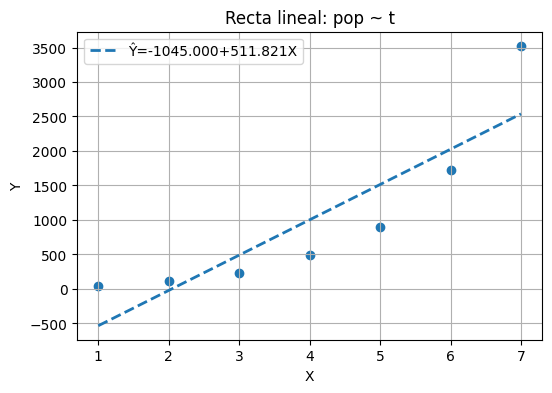

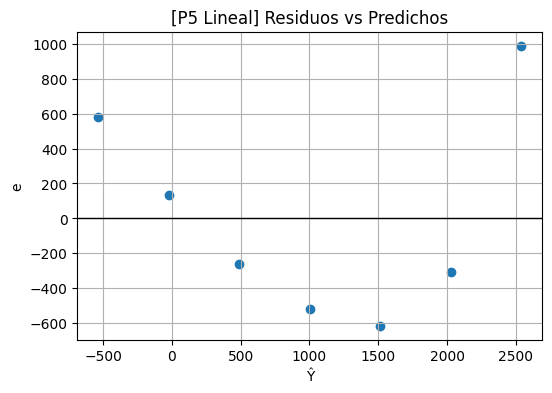

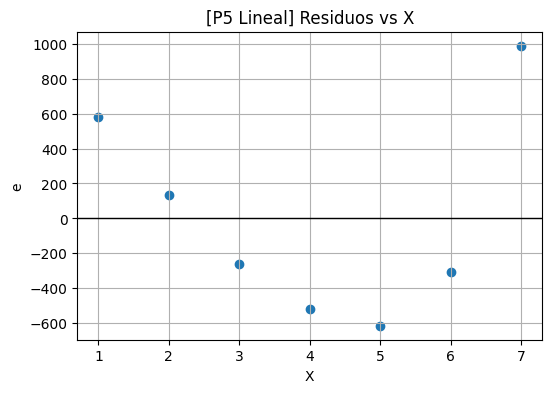

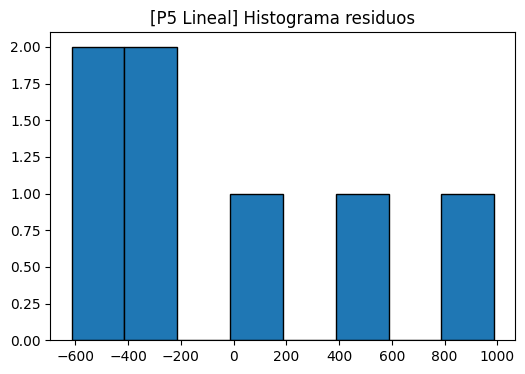

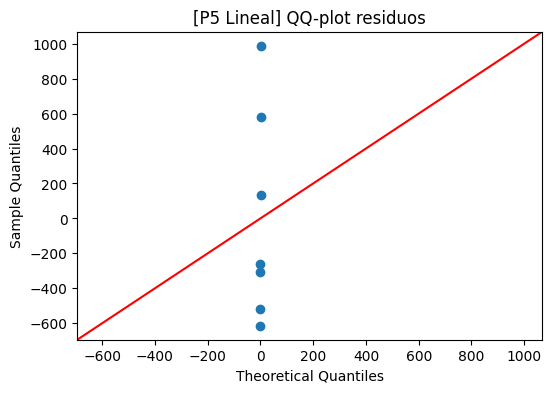

AttributeError: 'PandasData' object has no attribute 'design_info'

In [16]:
df5 = pd.DataFrame({
    "t":[1,2,3,4,5,6,7],
    "pop":[45,112,228,485,900,1720,3526]
})

# (a) Gráfico
plot_scatter_with_line(df5["t"], df5["pop"], title="Tiempo vs Población")

# (b) Modelo lineal clásico
res_lin = fit_linear(df5["t"], df5["pop"])
print(res_lin.summary())
plot_scatter_with_line(df5["t"], df5["pop"], res_lin.params["const"], res_lin.params["t"],
                       "Recta lineal: pop ~ t")
plot_residual_diagnostics(res_lin, df5["t"], df5["pop"], "[P5 Lineal] ")
display(regression_anova(res_lin))
print(f"R^2 lineal = {res_lin.rsquared:.4f}")

# (c) Transformación log(Y)
df5["logpop"] = np.log(df5["pop"])  # puedes usar np.log10 si piden base 10
plot_scatter_with_line(df5["t"], df5["logpop"], title="t vs log(pop)")
res_log = fit_linear(df5["t"], df5["logpop"])
print(res_log.summary())
plot_scatter_with_line(df5["t"], df5["logpop"], res_log.params["const"], res_log.params["t"],
                       "Recta: log(pop) ~ t")
plot_residual_diagnostics(res_log, df5["t"], df5["logpop"], "[P5 Log] ")
display(regression_anova(res_log))
print(f"R^2 log = {res_log.rsquared:.4f}")

# (e) Interpretación del coeficiente en el modelo log:
b1 = res_log.params["t"]
print(f"En log-natural: d(log Y)/dX = {b1:.4f} ⇒ crecimiento ≈ {100*(np.exp(b1)-1):.2f}% por hora.")

# (f) Comparación de supuestos y recomendación: (ver residuales y R^2 en outputs)

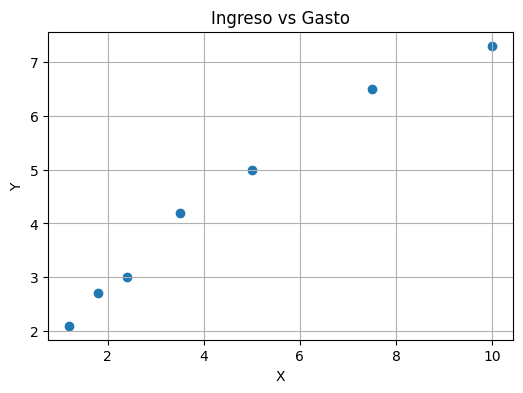

                            OLS Regression Results                            
Dep. Variable:                  gasto   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     181.0
Date:                Fri, 07 Nov 2025   Prob (F-statistic):           4.06e-05
Time:                        12:18:49   Log-Likelihood:                -1.4930
No. Observations:                   7   AIC:                             6.986
Df Residuals:                       5   BIC:                             6.878
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7074      0.241      7.090      0.0

/usr/local/lib/python3.12/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


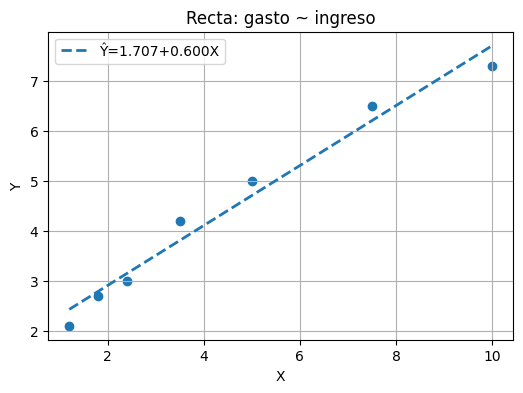

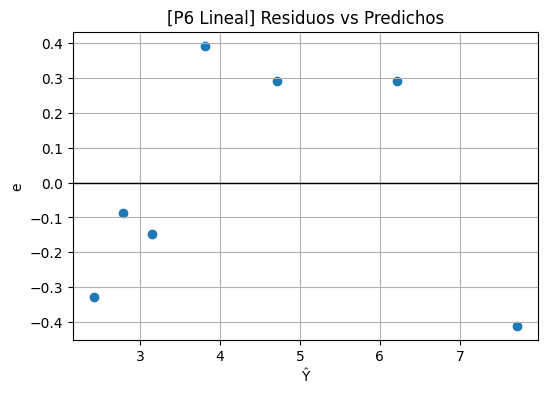

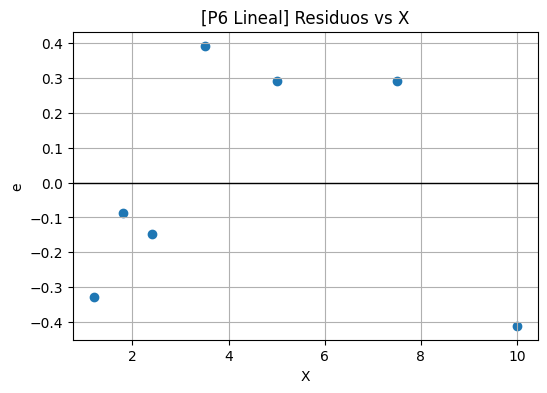

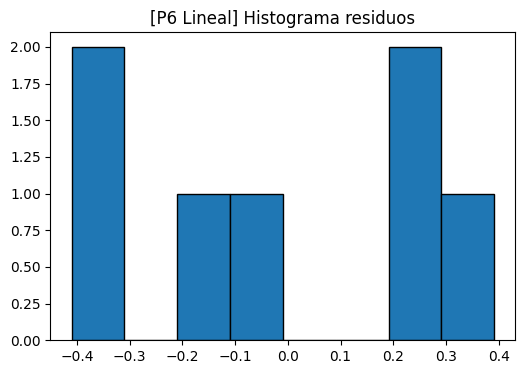

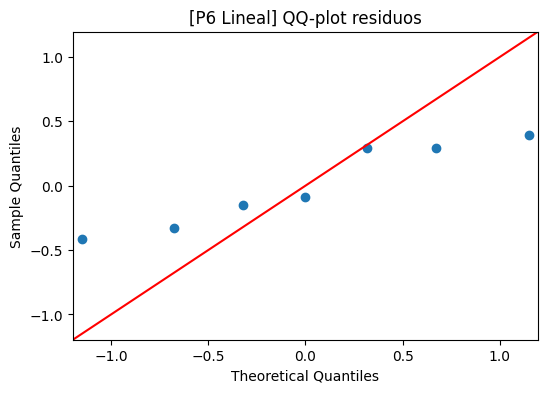

AttributeError: 'PandasData' object has no attribute 'design_info'

In [17]:
df6 = pd.DataFrame({
    "ingreso":[1.2,1.8,2.4,3.5,5.0,7.5,10.0],
    "gasto":[2.1,2.7,3.0,4.2,5.0,6.5,7.3]
})

# (a) Modelo original
plot_scatter_with_line(df6["ingreso"], df6["gasto"], title="Ingreso vs Gasto")
res_lin = fit_linear(df6["ingreso"], df6["gasto"])
print(res_lin.summary())
plot_scatter_with_line(df6["ingreso"], df6["gasto"], res_lin.params["const"], res_lin.params["ingreso"],
                       "Recta: gasto ~ ingreso")
plot_residual_diagnostics(res_lin, df6["ingreso"], df6["gasto"], "[P6 Lineal] ")
display(regression_anova(res_lin))
print(f"R^2 lineal = {res_lin.rsquared:.4f}")

# (b) Transformaciones log
df6["log_ing"] = np.log(df6["ingreso"])
df6["log_gasto"] = np.log(df6["gasto"])

# (c) Modelo log–log
plot_scatter_with_line(df6["log_ing"], df6["log_gasto"], title="log(gasto) vs log(ingreso)")
res_ll = fit_linear(df6["log_ing"], df6["log_gasto"])
print(res_ll.summary())
plot_scatter_with_line(df6["log_ing"], df6["log_gasto"], res_ll.params["const"], res_ll.params["log_ing"],
                       "Recta: log(gasto) ~ log(ingreso)")
plot_residual_diagnostics(res_ll, df6["log_ing"], df6["log_gasto"], "[P6 Log-Log] ")
display(regression_anova(res_ll))
print(f"R^2 log-log = {res_ll.rsquared:.4f}")

# (d) Elasticidad = pendiente en log-log
elas = res_ll.params["log_ing"]
print(f"Elasticidad (log-log) = {elas:.3f} ⇒ 1% más ingreso ≈ {elas:.3f}% más gasto.")

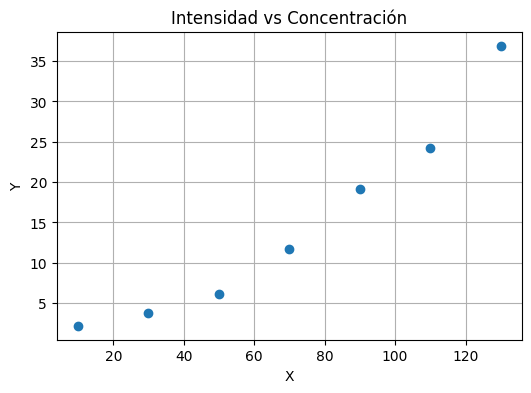

/usr/local/lib/python3.12/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


                            OLS Regression Results                            
Dep. Variable:                   conc   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     64.07
Date:                Fri, 07 Nov 2025   Prob (F-statistic):           0.000492
Time:                        12:18:51   Log-Likelihood:                -17.971
No. Observations:                   7   AIC:                             39.94
Df Residuals:                       5   BIC:                             39.83
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.8786      2.842     -1.717      0.1

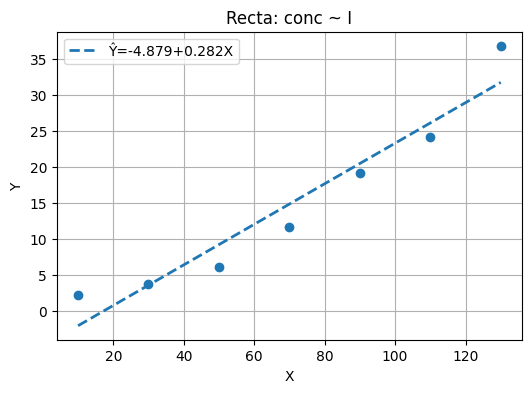

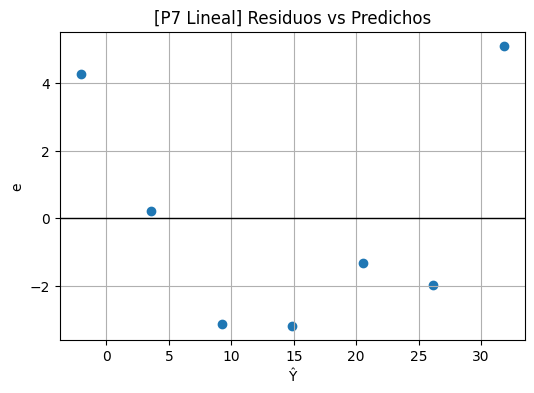

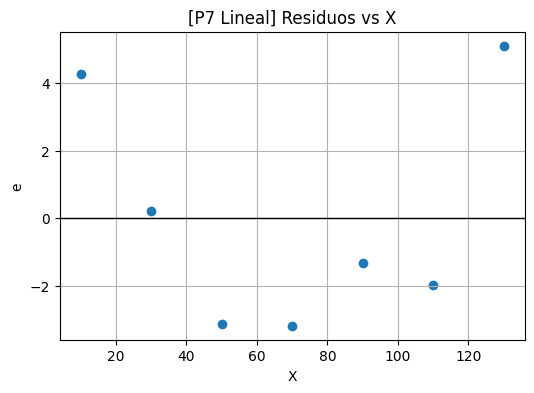

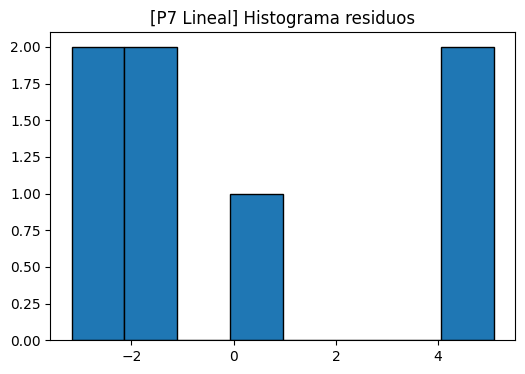

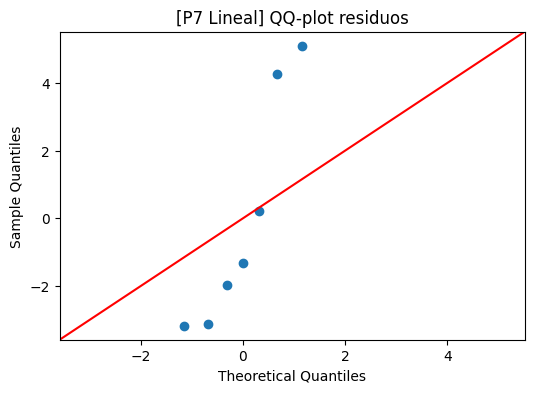

AttributeError: 'PandasData' object has no attribute 'design_info'

In [18]:
df7 = pd.DataFrame({
    "I":[10,30,50,70,90,110,130],
    "conc":[2.2,3.8,6.1,11.7,19.2,24.2,36.9]
})

# (a) Modelo clásico
plot_scatter_with_line(df7["I"], df7["conc"], title="Intensidad vs Concentración")
res_lin = fit_linear(df7["I"], df7["conc"])
print(res_lin.summary())
plot_scatter_with_line(df7["I"], df7["conc"], res_lin.params["const"], res_lin.params["I"],
                       "Recta: conc ~ I")
plot_residual_diagnostics(res_lin, df7["I"], df7["conc"], "[P7 Lineal] ")
display(regression_anova(res_lin))
print(f"R^2 lineal = {res_lin.rsquared:.4f}")

# (b) Transformación Y' = sqrt(Y)
df7["sqrt_conc"] = np.sqrt(df7["conc"])
plot_scatter_with_line(df7["I"], df7["sqrt_conc"], title="I vs sqrt(conc)")
res_sqrt = fit_linear(df7["I"], df7["sqrt_conc"])
print(res_sqrt.summary())
plot_scatter_with_line(df7["I"], df7["sqrt_conc"], res_sqrt.params["const"], res_sqrt.params["I"],
                       "Recta: sqrt(conc) ~ I")
plot_residual_diagnostics(res_sqrt, df7["I"], df7["sqrt_conc"], "[P7 sqrt] ")
display(regression_anova(res_sqrt))
print(f"R^2 sqrt = {res_sqrt.rsquared:.4f}")

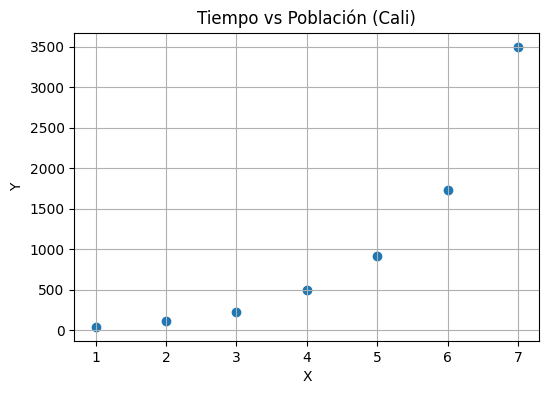

/usr/local/lib/python3.12/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


                            OLS Regression Results                            
Dep. Variable:                    pop   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                     17.76
Date:                Fri, 07 Nov 2025   Prob (F-statistic):            0.00837
Time:                        12:18:52   Log-Likelihood:                -54.001
No. Observations:                   7   AIC:                             112.0
Df Residuals:                       5   BIC:                             111.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1042.4286    542.083     -1.923      0.1

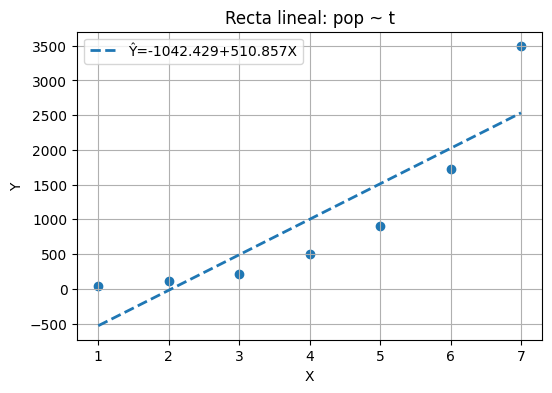

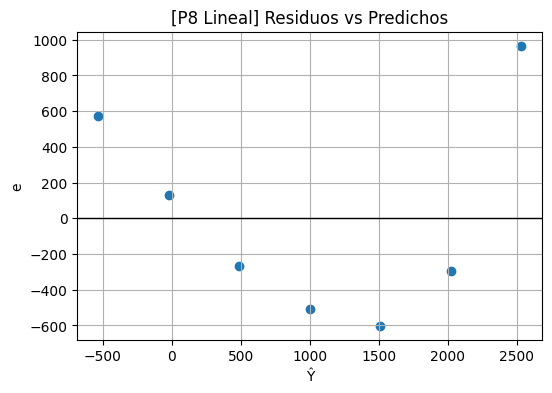

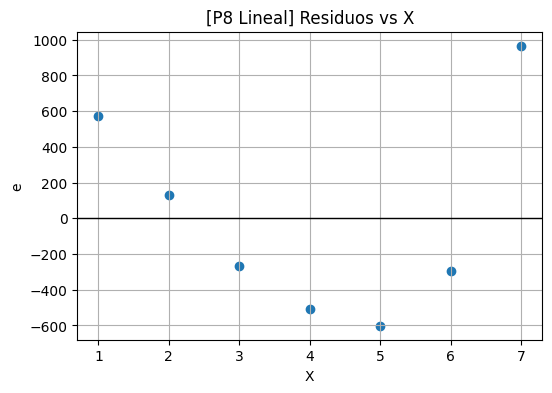

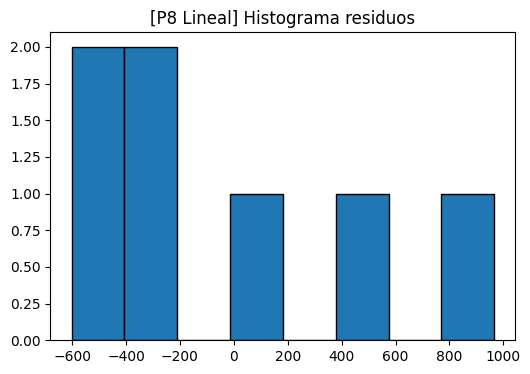

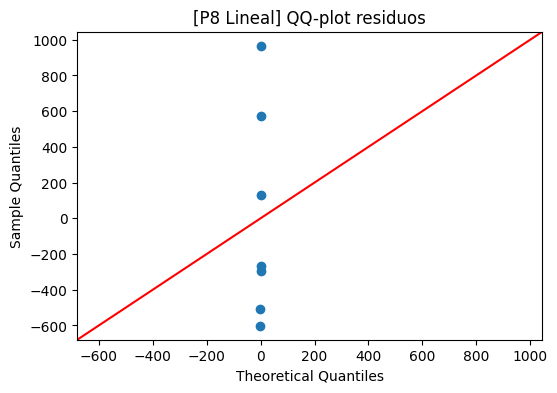

AttributeError: 'PandasData' object has no attribute 'design_info'

In [19]:
df8 = pd.DataFrame({
    "t":[1,2,3,4,5,6,7],
    "pop":[42,110,220,495,910,1730,3500]
})

# (a) Gráfico
plot_scatter_with_line(df8["t"], df8["pop"], title="Tiempo vs Población (Cali)")

# (b) Modelo lineal
res_lin = fit_linear(df8["t"], df8["pop"])
print(res_lin.summary())
plot_scatter_with_line(df8["t"], df8["pop"], res_lin.params["const"], res_lin.params["t"],
                       "Recta lineal: pop ~ t")
plot_residual_diagnostics(res_lin, df8["t"], df8["pop"], "[P8 Lineal] ")
display(regression_anova(res_lin))
print(f"R^2 lineal = {res_lin.rsquared:.4f}")

# (c) log(Y)
df8["logpop"] = np.log(df8["pop"])
plot_scatter_with_line(df8["t"], df8["logpop"], title="t vs log(pop)")
res_log = fit_linear(df8["t"], df8["logpop"])
print(res_log.summary())
plot_scatter_with_line(df8["t"], df8["logpop"], res_log.params["const"], res_log.params["t"],
                       "Recta: log(pop) ~ t")
plot_residual_diagnostics(res_log, df8["t"], df8["logpop"], "[P8 Log] ")
display(regression_anova(res_log))
print(f"R^2 log = {res_log.rsquared:.4f}")

# (e) Interpretación de b1 en log
b1 = res_log.params["t"]
print(f"Crecimiento aproximado: {100*(np.exp(b1)-1):.2f}% por hora.")

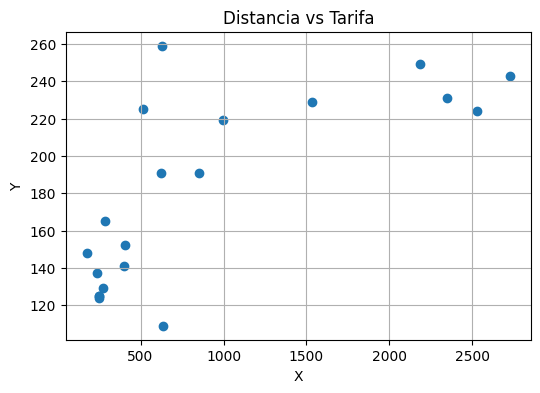

r=0.7253, p(two)=0.0002959, t=4.470, gl=18


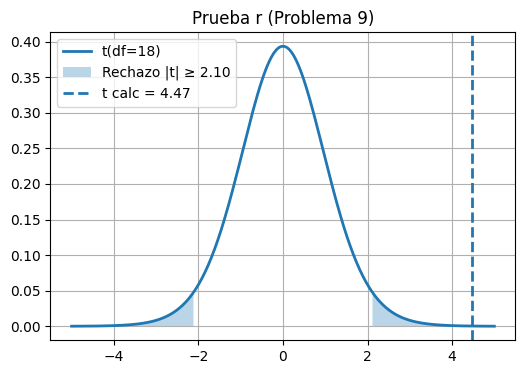

R^2 = 0.5261  (52.61%)
                            OLS Regression Results                            
Dep. Variable:                   fare   R-squared:                       0.526
Model:                            OLS   Adj. R-squared:                  0.500
Method:                 Least Squares   F-statistic:                     19.98
Date:                Fri, 07 Nov 2025   Prob (F-statistic):           0.000296
Time:                        12:18:54   Log-Likelihood:                -98.726
No. Observations:                  20   AIC:                             201.5
Df Residuals:                      18   BIC:                             203.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        142.4328     11.

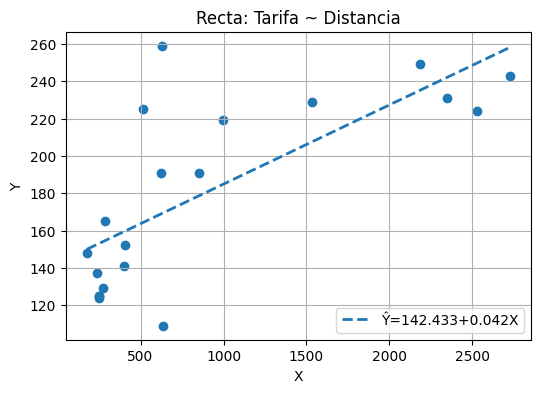

Cada milla añade ≈ 0.0424 USD.


ValueError: shapes (1,1) and (2,) not aligned: 1 (dim 1) != 2 (dim 0)

In [20]:
dist = np.array([636,275,398,405,286,627,2346,177,2528,248,512,248,248,237,621,853,2181,1531,2724,999], dtype=float)
fare = np.array([109,129,141,152,165,259,231,148,224,125,225,124,125,137,191,191,249,229,243,219], dtype=float)
df9 = pd.DataFrame({"dist": dist, "fare": fare})

# (a) Dispersión
plot_scatter_with_line(df9["dist"], df9["fare"], title="Distancia vs Tarifa")

# (b) Correlación Pearson y prueba H0: rho>0 (equivalente a dos colas con r>0 o cola derecha en t)
r, p = stats.pearsonr(df9["dist"], df9["fare"])
n = len(df9); t_stat, gl, p_two = pearson_t_test(r, n)
print(f"r={r:.4f}, p(two)={p_two:.4g}, t={t_stat:.3f}, gl={gl}")
t_curve_for_rtest(t_stat, gl, 0.05, "two-sided", "Prueba r (Problema 9)")

# (c) R^2
print(f"R^2 = {r**2:.4f}  ({100*r**2:.2f}%)")

# (d) Regresión
res = fit_linear(df9["dist"], df9["fare"])
print(res.summary())
b0, b1 = res.params["const"], res.params["dist"]
plot_scatter_with_line(df9["dist"], df9["fare"], b0, b1, "Recta: Tarifa ~ Distancia")

print(f"Cada milla añade ≈ {b1:.4f} USD.")
x_pred = 1500
pred = conf_pred_intervals(res, pd.Series([x_pred]))
display(pred.loc[:, ["yhat","IC_low","IC_high","PI_low","PI_high"]])

# (e) Extrapolación (4218 millas)
print("⚠️ Extrapolación: 4218 mi está fuera del rango observado ("
      f"{df9['dist'].min()}–{df9['dist'].max()} mi). No es aconsejable usar la recta.")